# Feature Engineering Notebook 2

## Goal
The goal of this notebook is to enhance the dataset by applying various techniques to extract valuable insights and improve the predictive power of the model. The primary objectives are as follows:

1. **Filter Subtle Noise:** Identify and filter out subtle noise from the dataset, distinguishing it from outliers, to ensure data integrity and quality.
    
2. **Feature Generation:** Create new features by leveraging numerical, temporal, frequency, and clustering techniques, enriching the dataset and capturing additional information that may be relevant for modeling.

In [1]:
DF_PATH = '../data/processed/5a_feature_engineering_data.pkl'
FIG_DIR = '../reports/figures/'
EXPORT_PATH = '../data/processed/5b_feature_engineering_clustered_data.pkl'

In [2]:
import sys
sys.path.append('../')

In [3]:
# Load packages
import pandas as pd 
import numpy as np
import logging
import pickle
import os
import plotly.graph_objects as go 
from plotly.subplots import make_subplots
import plotly.express as px 
import plotly.figure_factory as ff 
from matplotlib import pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import seaborn as sns
from IPython.display import display
from cycler import cycler
from scipy.signal import butter, lfilter, filtfilt
from sklearn.decomposition import PCA
import scipy.stats as stats
from sklearn.cluster import KMeans

In [4]:
from scripts.NumericalAbstraction import *
from scripts.FourierTransformation import *

In [5]:
# Ajust matplotlib style Function using (GPT-3.5)
class CustomMatplotlibStyle:
    def __init__(self, custom_colors=None, legend_fontsize=10):
        if custom_colors is None:
            custom_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
        self.set_colors(custom_colors)
        self.set_style()
        self.set_figure_size()
        self.set_grid()
        self.set_line_width()
        self.set_tick_colors()
        self.set_font_size()
        self.set_title_size()
        self.set_legend_fontsize(legend_fontsize)
        self.set_dpi()

    def set_colors(self, custom_colors):
        plt.rcParams["axes.prop_cycle"] = cycler(color=custom_colors)

    def set_style(self):
        plt.style.use("bmh")

    def set_figure_size(self):
        plt.rcParams["figure.figsize"] = (20, 10)

    def set_grid(self):
        plt.rcParams["axes.grid"] = True
        plt.rcParams["grid.color"] = "lightgray"

    def set_line_width(self):
        plt.rcParams["axes.linewidth"] = 1.5

    def set_tick_colors(self):
        plt.rcParams["xtick.color"] = "black"
        plt.rcParams["ytick.color"] = "black"

    def set_font_size(self):
        plt.rcParams["font.size"] = 15

    def set_title_size(self):
        plt.rcParams["figure.titlesize"] = 20

    def set_legend_fontsize(self, legend_fontsize):
        plt.rcParams["legend.fontsize"] = legend_fontsize

    def set_dpi(self):
        plt.rcParams["figure.dpi"] = 100

custom_style = CustomMatplotlibStyle(legend_fontsize=8)


------

# **Read Data**

In [6]:
df = pd.read_pickle(DF_PATH)
df

,mean_xc,mean_yc,mean_zc,mean_xg,mean_yg,mean_zg,posture,types,specimen,set,duration_time,pca_1,pca_2,pca_3,acc_sqrt,gyro_sqrt
time,,,,,,,,,,,,,,,,
2024-02-11 17:08:05.200,0.013496,0.977014,-0.071002,-1.891570,2.438321,0.937917,bench,heavy,B,64.0,16.0,-2.134776,-4.437109,1.623949,0.979684,3.225389
2024-02-11 17:08:05.400,0.008260,0.965687,-0.066392,0.744158,0.512027,0.769823,bench,heavy,B,64.0,16.0,0.050828,-2.010353,1.483171,0.968002,1.186832
2024-02-11 17:08:05.600,-0.008713,0.964964,-0.072315,3.729410,-2.209350,-1.100146,bench,heavy,B,64.0,16.0,3.466693,0.352307,-0.118136,0.967709,4.472142
2024-02-11 17:08:05.800,-0.024124,0.973185,-0.084830,3.502448,-3.556205,-1.863756,bench,heavy,B,64.0,16.0,3.667741,0.963988,-1.544392,0.977173,5.327976
2024-02-11 17:08:06.000,-0.021642,0.963600,-0.095993,2.250385,-0.890134,-1.990244,bench,heavy,B,64.0,16.0,2.811832,-1.674566,-0.545874,0.968612,3.133311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-20 19:33:27.000,-0.043888,-0.983254,-0.062298,2.477314,-4.130471,0.211078,row,medium,E,71.0,19.0,1.621374,2.037572,-0.961822,0.986202,4.821040
2024-02-20 19:33:27.200,-0.041612,-1.045090,-0.060838,-1.825996,-2.528451,1.485679,row,medium,E,71.0,19.0,-2.575507,-0.219284,-1.010687,1.047685,3.454645
2024-02-20 19:33:27.400,-0.047711,-1.047383,-0.066148,-0.261306,-1.974637,1.149337,row,medium,E,71.0,19.0,-1.080412,-0.236535,-0.215415,1.050554,2.299662


In [7]:
predicator_columns = list(df.columns[0:6]) + list(df.columns[14:])
predicator_columns

['mean_xc',
 'mean_yc',
 'mean_zc',
 'mean_xg',
 'mean_yg',
 'mean_zg',
 'acc_sqrt',
 'gyro_sqrt']

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9009 entries, 2024-02-11 17:08:05.200000 to 2024-02-20 19:33:27.800000
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   mean_xc        9009 non-null   float64
 1   mean_yc        9009 non-null   float64
 2   mean_zc        9009 non-null   float64
 3   mean_xg        9009 non-null   float64
 4   mean_yg        9009 non-null   float64
 5   mean_zg        9009 non-null   float64
 6   posture        9009 non-null   object 
 7   types          9009 non-null   object 
 8   specimen       9009 non-null   object 
 9   set            9009 non-null   float64
 10  duration_time  9009 non-null   float64
 11  pca_1          9009 non-null   float64
 12  pca_2          9009 non-null   float64
 13  pca_3          9009 non-null   float64
 14  acc_sqrt       9009 non-null   float64
 15  gyro_sqrt      9009 non-null   float64
dtypes: float64(13), object(3)
memory usage: 1.2+ M

In [9]:
subset_df = df[df['set'] == 14]

-----

# **Temporal abstraction**


In [10]:
df_abs = df.copy()
df_abs

,mean_xc,mean_yc,mean_zc,mean_xg,mean_yg,mean_zg,posture,types,specimen,set,duration_time,pca_1,pca_2,pca_3,acc_sqrt,gyro_sqrt
time,,,,,,,,,,,,,,,,
2024-02-11 17:08:05.200,0.013496,0.977014,-0.071002,-1.891570,2.438321,0.937917,bench,heavy,B,64.0,16.0,-2.134776,-4.437109,1.623949,0.979684,3.225389
2024-02-11 17:08:05.400,0.008260,0.965687,-0.066392,0.744158,0.512027,0.769823,bench,heavy,B,64.0,16.0,0.050828,-2.010353,1.483171,0.968002,1.186832
2024-02-11 17:08:05.600,-0.008713,0.964964,-0.072315,3.729410,-2.209350,-1.100146,bench,heavy,B,64.0,16.0,3.466693,0.352307,-0.118136,0.967709,4.472142
2024-02-11 17:08:05.800,-0.024124,0.973185,-0.084830,3.502448,-3.556205,-1.863756,bench,heavy,B,64.0,16.0,3.667741,0.963988,-1.544392,0.977173,5.327976
2024-02-11 17:08:06.000,-0.021642,0.963600,-0.095993,2.250385,-0.890134,-1.990244,bench,heavy,B,64.0,16.0,2.811832,-1.674566,-0.545874,0.968612,3.133311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-20 19:33:27.000,-0.043888,-0.983254,-0.062298,2.477314,-4.130471,0.211078,row,medium,E,71.0,19.0,1.621374,2.037572,-0.961822,0.986202,4.821040
2024-02-20 19:33:27.200,-0.041612,-1.045090,-0.060838,-1.825996,-2.528451,1.485679,row,medium,E,71.0,19.0,-2.575507,-0.219284,-1.010687,1.047685,3.454645
2024-02-20 19:33:27.400,-0.047711,-1.047383,-0.066148,-0.261306,-1.974637,1.149337,row,medium,E,71.0,19.0,-1.080412,-0.236535,-0.215415,1.050554,2.299662


In [11]:
num_abstraction = NumericalAbstraction()
window_size = int(1000/200) # the size of the rolling window as in function description 

In [12]:
for col in predicator_columns:
    df_abs = num_abstraction.abstract_numerical(df_abs, [col], window_size , 'mean')
    df_abs = num_abstraction.abstract_numerical(df_abs , [col], window_size , 'std')

In [13]:
df_abs

,mean_xc,mean_yc,mean_zc,mean_xg,mean_yg,mean_zg,posture,types,specimen,set,...,mean_xg_temp_mean_ws_5,mean_xg_temp_std_ws_5,mean_yg_temp_mean_ws_5,mean_yg_temp_std_ws_5,mean_zg_temp_mean_ws_5,mean_zg_temp_std_ws_5,acc_sqrt_temp_mean_ws_5,acc_sqrt_temp_std_ws_5,gyro_sqrt_temp_mean_ws_5,gyro_sqrt_temp_std_ws_5
time,,,,,,,,,,,,,,,,,,,,,
2024-02-11 17:08:05.200,0.013496,0.977014,-0.071002,-1.891570,2.438321,0.937917,bench,heavy,B,64.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-02-11 17:08:05.400,0.008260,0.965687,-0.066392,0.744158,0.512027,0.769823,bench,heavy,B,64.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-02-11 17:08:05.600,-0.008713,0.964964,-0.072315,3.729410,-2.209350,-1.100146,bench,heavy,B,64.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-02-11 17:08:05.800,-0.024124,0.973185,-0.084830,3.502448,-3.556205,-1.863756,bench,heavy,B,64.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-02-11 17:08:06.000,-0.021642,0.963600,-0.095993,2.250385,-0.890134,-1.990244,bench,heavy,B,64.0,...,1.666966,2.072573,-0.741068,2.087191,-0.649281,1.265659,0.972236,0.005126,3.469130,1.403026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-20 19:33:27.000,-0.043888,-0.983254,-0.062298,2.477314,-4.130471,0.211078,row,medium,E,71.0,...,-8.452735,12.790836,0.682825,5.433990,7.142625,6.248818,1.082551,0.120607,15.358002,10.919950
2024-02-20 19:33:27.200,-0.041612,-1.045090,-0.060838,-1.825996,-2.528451,1.485679,row,medium,E,71.0,...,-3.608194,9.327112,-1.541708,3.758211,4.426163,5.050395,1.101973,0.104539,9.789731,8.110097
2024-02-20 19:33:27.400,-0.047711,-1.047383,-0.066148,-0.261306,-1.974637,1.149337,row,medium,E,71.0,...,0.559182,3.269307,-3.054094,1.307585,1.940046,2.171398,1.062573,0.075271,5.108591,2.102230


- When analyzing the new dataset after loop results, a significant issue arises introducing noise or errors into the data. This occurs when looking back over several data points, typically five steps, and iterating through the entire dataframe whenever transitioning from one exercise set to another. For instance, when transitioning from a squat to a bench press set, the first row of the new set (bench press) would reference values from the preceding squat set. Consequently, the computation of mean values and standard deviations includes data from a different exercise, resulting in inaccuracies and introducing irrelevant information into subsequent sets. This contamination of data undermines the integrity of the dataset and may adversely affect the performance of any model trained on it. Therefore, it is imperative to address this issue to ensure the accuracy and reliability of the dataset for modeling purposes.


- Okay how to solve this Let's start:


In [14]:
df_abs_list = [] 
for s in df_abs['set'].unique():
    subset_df = df_abs[df_abs['set'] == s].copy()
    for col in predicator_columns:
        subset_df = num_abstraction.abstract_numerical(subset_df , [col], window_size , 'mean')
        subset_df = num_abstraction.abstract_numerical(subset_df , [col], window_size , 'std')
    df_abs_list.append(subset_df)
df_abs = pd.concat(df_abs_list)

In [15]:
df_abs

,mean_xc,mean_yc,mean_zc,mean_xg,mean_yg,mean_zg,posture,types,specimen,set,...,mean_xg_temp_mean_ws_5,mean_xg_temp_std_ws_5,mean_yg_temp_mean_ws_5,mean_yg_temp_std_ws_5,mean_zg_temp_mean_ws_5,mean_zg_temp_std_ws_5,acc_sqrt_temp_mean_ws_5,acc_sqrt_temp_std_ws_5,gyro_sqrt_temp_mean_ws_5,gyro_sqrt_temp_std_ws_5
time,,,,,,,,,,,,,,,,,,,,,
2024-02-11 17:08:05.200,0.013496,0.977014,-0.071002,-1.891570,2.438321,0.937917,bench,heavy,B,64.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-02-11 17:08:05.400,0.008260,0.965687,-0.066392,0.744158,0.512027,0.769823,bench,heavy,B,64.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-02-11 17:08:05.600,-0.008713,0.964964,-0.072315,3.729410,-2.209350,-1.100146,bench,heavy,B,64.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-02-11 17:08:05.800,-0.024124,0.973185,-0.084830,3.502448,-3.556205,-1.863756,bench,heavy,B,64.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-02-11 17:08:06.000,-0.021642,0.963600,-0.095993,2.250385,-0.890134,-1.990244,bench,heavy,B,64.0,...,1.666966,2.072573,-0.741068,2.087191,-0.649281,1.265659,0.972236,0.005126,3.469130,1.403026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-20 19:33:27.000,-0.043888,-0.983254,-0.062298,2.477314,-4.130471,0.211078,row,medium,E,71.0,...,-8.452735,12.790836,0.682825,5.433990,7.142625,6.248818,1.082551,0.120607,15.358002,10.919950
2024-02-20 19:33:27.200,-0.041612,-1.045090,-0.060838,-1.825996,-2.528451,1.485679,row,medium,E,71.0,...,-3.608194,9.327112,-1.541708,3.758211,4.426163,5.050395,1.101973,0.104539,9.789731,8.110097
2024-02-20 19:33:27.400,-0.047711,-1.047383,-0.066148,-0.261306,-1.974637,1.149337,row,medium,E,71.0,...,0.559182,3.269307,-3.054094,1.307585,1.940046,2.171398,1.062573,0.075271,5.108591,2.102230


In [16]:
df_abs.columns

Index(['mean_xc', 'mean_yc', 'mean_zc', 'mean_xg', 'mean_yg', 'mean_zg',
       'posture', 'types', 'specimen ', 'set', 'duration_time', 'pca_1',
       'pca_2', 'pca_3', 'acc_sqrt', 'gyro_sqrt', 'mean_xc_temp_mean_ws_5',
       'mean_xc_temp_std_ws_5', 'mean_yc_temp_mean_ws_5',
       'mean_yc_temp_std_ws_5', 'mean_zc_temp_mean_ws_5',
       'mean_zc_temp_std_ws_5', 'mean_xg_temp_mean_ws_5',
       'mean_xg_temp_std_ws_5', 'mean_yg_temp_mean_ws_5',
       'mean_yg_temp_std_ws_5', 'mean_zg_temp_mean_ws_5',
       'mean_zg_temp_std_ws_5', 'acc_sqrt_temp_mean_ws_5',
       'acc_sqrt_temp_std_ws_5', 'gyro_sqrt_temp_mean_ws_5',
       'gyro_sqrt_temp_std_ws_5'],
      dtype='object')

In [17]:
subset_df[['mean_yc' , 'mean_yc_temp_mean_ws_5' , 'mean_yc_temp_std_ws_5']]

,mean_yc,mean_yc_temp_mean_ws_5,mean_yc_temp_std_ws_5
time,,,
2024-02-20 19:33:08.400,-1.027651,NaN,NaN
2024-02-20 19:33:08.600,-1.015629,NaN,NaN
2024-02-20 19:33:08.800,-1.041640,NaN,NaN
2024-02-20 19:33:09.000,-1.036518,NaN,NaN
2024-02-20 19:33:09.200,-0.999448,-1.024177,0.015192
...,...,...,...
2024-02-20 19:33:27.000,-0.983254,-1.078065,0.122111
2024-02-20 19:33:27.200,-1.045090,-1.098620,0.104978
2024-02-20 19:33:27.400,-1.047383,-1.058756,0.074637


- Plotting Accelemeter data 

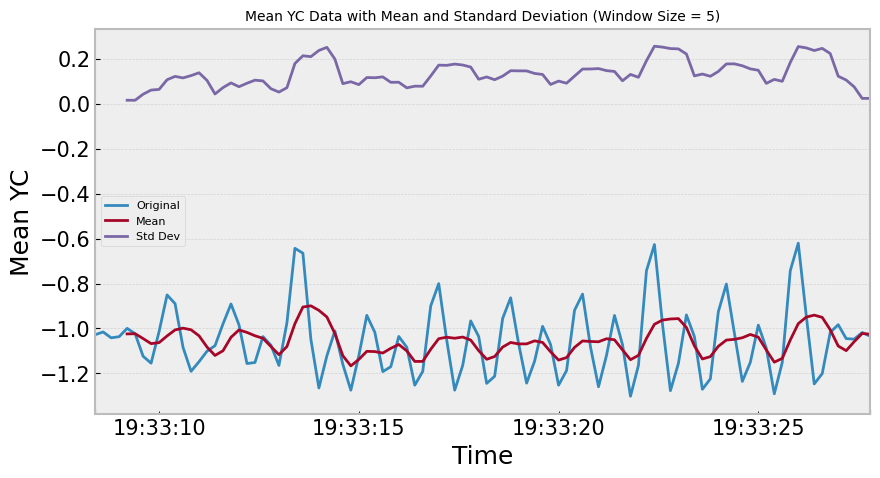

In [18]:
# Plotting mean_yc data with mean and standard deviation
fig, ax = plt.subplots(figsize=(10, 5))
subset_df[['mean_yc', 'mean_yc_temp_mean_ws_5', 'mean_yc_temp_std_ws_5']].plot(ax=ax)
ax.set_xlabel("Time")
ax.set_ylabel("Mean YC")
ax.set_title("Mean YC Data with Mean and Standard Deviation (Window Size = 5)" , fontsize=10)
plt.legend(["Original", "Mean", "Std Dev"])
plt.show()

- Plotting Gyroscope data

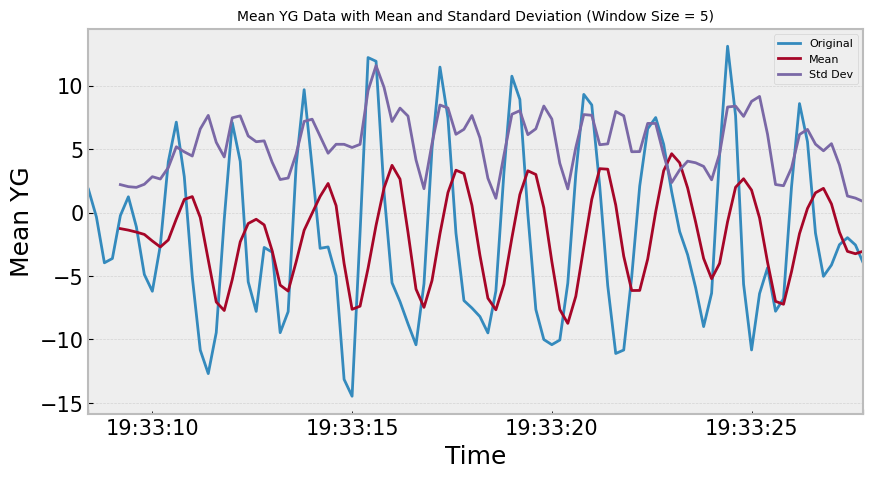

In [19]:
# Plotting mean_yg data with mean and standard deviation
fig, ax = plt.subplots(figsize=(10, 5))
subset_df[['mean_yg', 'mean_yg_temp_mean_ws_5', 'mean_yg_temp_std_ws_5']].plot(ax=ax)
ax.set_xlabel("Time")
ax.set_ylabel("Mean YG")
ax.set_title("Mean YG Data with Mean and Standard Deviation (Window Size = 5)", fontsize=10)
plt.legend(["Original", "Mean", "Std Dev"])
plt.show()

----

# **Discrete Fourier Transformation (DFT)**


In [20]:
df_DFT =  df_abs.copy().reset_index()
df_DFT

,time,mean_xc,mean_yc,mean_zc,mean_xg,mean_yg,mean_zg,posture,types,specimen,...,mean_xg_temp_mean_ws_5,mean_xg_temp_std_ws_5,mean_yg_temp_mean_ws_5,mean_yg_temp_std_ws_5,mean_zg_temp_mean_ws_5,mean_zg_temp_std_ws_5,acc_sqrt_temp_mean_ws_5,acc_sqrt_temp_std_ws_5,gyro_sqrt_temp_mean_ws_5,gyro_sqrt_temp_std_ws_5
0,2024-02-11 17:08:05.200,0.013496,0.977014,-0.071002,-1.891570,2.438321,0.937917,bench,heavy,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-02-11 17:08:05.400,0.008260,0.965687,-0.066392,0.744158,0.512027,0.769823,bench,heavy,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-02-11 17:08:05.600,-0.008713,0.964964,-0.072315,3.729410,-2.209350,-1.100146,bench,heavy,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-02-11 17:08:05.800,-0.024124,0.973185,-0.084830,3.502448,-3.556205,-1.863756,bench,heavy,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-02-11 17:08:06.000,-0.021642,0.963600,-0.095993,2.250385,-0.890134,-1.990244,bench,heavy,B,...,1.666966,2.072573,-0.741068,2.087191,-0.649281,1.265659,0.972236,0.005126,3.469130,1.403026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9004,2024-02-20 19:33:27.000,-0.043888,-0.983254,-0.062298,2.477314,-4.130471,0.211078,row,medium,E,...,-8.452735,12.790836,0.682825,5.433990,7.142625,6.248818,1.082551,0.120607,15.358002,10.919950
9005,2024-02-20 19:33:27.200,-0.041612,-1.045090,-0.060838,-1.825996,-2.528451,1.485679,row,medium,E,...,-3.608194,9.327112,-1.541708,3.758211,4.426163,5.050395,1.101973,0.104539,9.789731,8.110097
9006,2024-02-20 19:33:27.400,-0.047711,-1.047383,-0.066148,-0.261306,-1.974637,1.149337,row,medium,E,...,0.559182,3.269307,-3.054094,1.307585,1.940046,2.171398,1.062573,0.075271,5.108591,2.102230
9007,2024-02-20 19:33:27.600,-0.050471,-1.017967,-0.063349,2.227568,-2.549377,0.387236,row,medium,E,...,1.686835,2.611796,-3.241130,1.145026,0.778340,0.474786,1.025638,0.023201,4.339223,1.866890


In [21]:
# making instance of FourierTransformation
Freq_DFT = FourierTransformation()

In [22]:
# applying DFT function 
df_DFT = Freq_DFT.abstract_frequency(data_table = df_DFT, cols= ['mean_yc'] , window_size = 14, sampling_rate = 5)
df_DFT

,time,mean_xc,mean_yc,mean_zc,mean_xg,mean_yg,mean_zg,posture,types,specimen,...,mean_yc_freq_weighted,mean_yc_pse,mean_yc_freq_0.0_Hz_ws_14,mean_yc_freq_0.357_Hz_ws_14,mean_yc_freq_0.714_Hz_ws_14,mean_yc_freq_1.071_Hz_ws_14,mean_yc_freq_1.429_Hz_ws_14,mean_yc_freq_1.786_Hz_ws_14,mean_yc_freq_2.143_Hz_ws_14,mean_yc_freq_2.5_Hz_ws_14
0,2024-02-11 17:08:05.200,0.013496,0.977014,-0.071002,-1.891570,2.438321,0.937917,bench,heavy,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-02-11 17:08:05.400,0.008260,0.965687,-0.066392,0.744158,0.512027,0.769823,bench,heavy,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-02-11 17:08:05.600,-0.008713,0.964964,-0.072315,3.729410,-2.209350,-1.100146,bench,heavy,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-02-11 17:08:05.800,-0.024124,0.973185,-0.084830,3.502448,-3.556205,-1.863756,bench,heavy,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-02-11 17:08:06.000,-0.021642,0.963600,-0.095993,2.250385,-0.890134,-1.990244,bench,heavy,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9004,2024-02-20 19:33:27.000,-0.043888,-0.983254,-0.062298,2.477314,-4.130471,0.211078,row,medium,E,...,-0.157350,0.035371,-15.476057,-0.219319,0.872613,0.525247,0.139468,0.140507,0.131847,0.129767
9005,2024-02-20 19:33:27.200,-0.041612,-1.045090,-0.060838,-1.825996,-2.528451,1.485679,row,medium,E,...,-0.065320,0.082371,-15.718760,-0.614676,0.912004,-1.165943,0.646232,0.186998,0.132868,0.115070
9006,2024-02-20 19:33:27.400,-0.047711,-1.047383,-0.066148,-0.261306,-1.974637,1.149337,row,medium,E,...,0.086096,0.051243,-15.746567,-0.686448,0.571984,-1.011729,-0.028958,-0.070899,-0.081632,-0.084976
9007,2024-02-20 19:33:27.600,-0.050471,-1.017967,-0.063349,2.227568,-2.549377,0.387236,row,medium,E,...,0.082989,0.033787,-15.529074,-0.413032,0.026796,0.635675,-0.635106,-0.197039,-0.148932,-0.133765


In [23]:
df_DFT.columns

Index(['time', 'mean_xc', 'mean_yc', 'mean_zc', 'mean_xg', 'mean_yg',
       'mean_zg', 'posture', 'types', 'specimen ', 'set', 'duration_time',
       'pca_1', 'pca_2', 'pca_3', 'acc_sqrt', 'gyro_sqrt',
       'mean_xc_temp_mean_ws_5', 'mean_xc_temp_std_ws_5',
       'mean_yc_temp_mean_ws_5', 'mean_yc_temp_std_ws_5',
       'mean_zc_temp_mean_ws_5', 'mean_zc_temp_std_ws_5',
       'mean_xg_temp_mean_ws_5', 'mean_xg_temp_std_ws_5',
       'mean_yg_temp_mean_ws_5', 'mean_yg_temp_std_ws_5',
       'mean_zg_temp_mean_ws_5', 'mean_zg_temp_std_ws_5',
       'acc_sqrt_temp_mean_ws_5', 'acc_sqrt_temp_std_ws_5',
       'gyro_sqrt_temp_mean_ws_5', 'gyro_sqrt_temp_std_ws_5',
       'mean_yc_max_freq', 'mean_yc_freq_weighted', 'mean_yc_pse',
       'mean_yc_freq_0.0_Hz_ws_14', 'mean_yc_freq_0.357_Hz_ws_14',
       'mean_yc_freq_0.714_Hz_ws_14', 'mean_yc_freq_1.071_Hz_ws_14',
       'mean_yc_freq_1.429_Hz_ws_14', 'mean_yc_freq_1.786_Hz_ws_14',
       'mean_yc_freq_2.143_Hz_ws_14', 'mean_yc_freq_2.

- we can see that starting from `'mean_yc_max_freq'` these are columns that were added as max frequency weighted and the power spectral antropy then all the different amplitudes of the signal.

In [24]:
df_subset = df_DFT[df_DFT['set'] == 15]

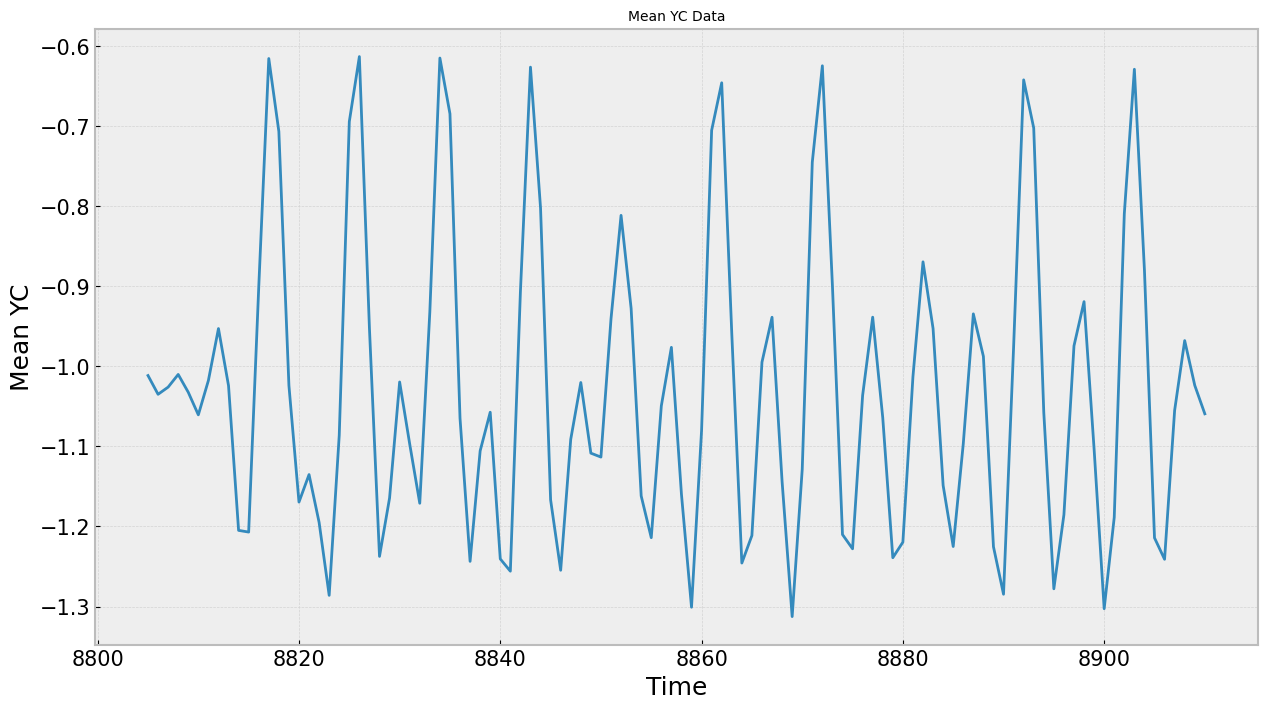

In [25]:
# Plotting mean_yc data
plt.figure(figsize=(15, 8))
plt.plot(df_subset['mean_yc'])
plt.xlabel('Time')
plt.ylabel('Mean YC')
plt.title('Mean YC Data', fontsize=10)
plt.grid(True)
plt.show()

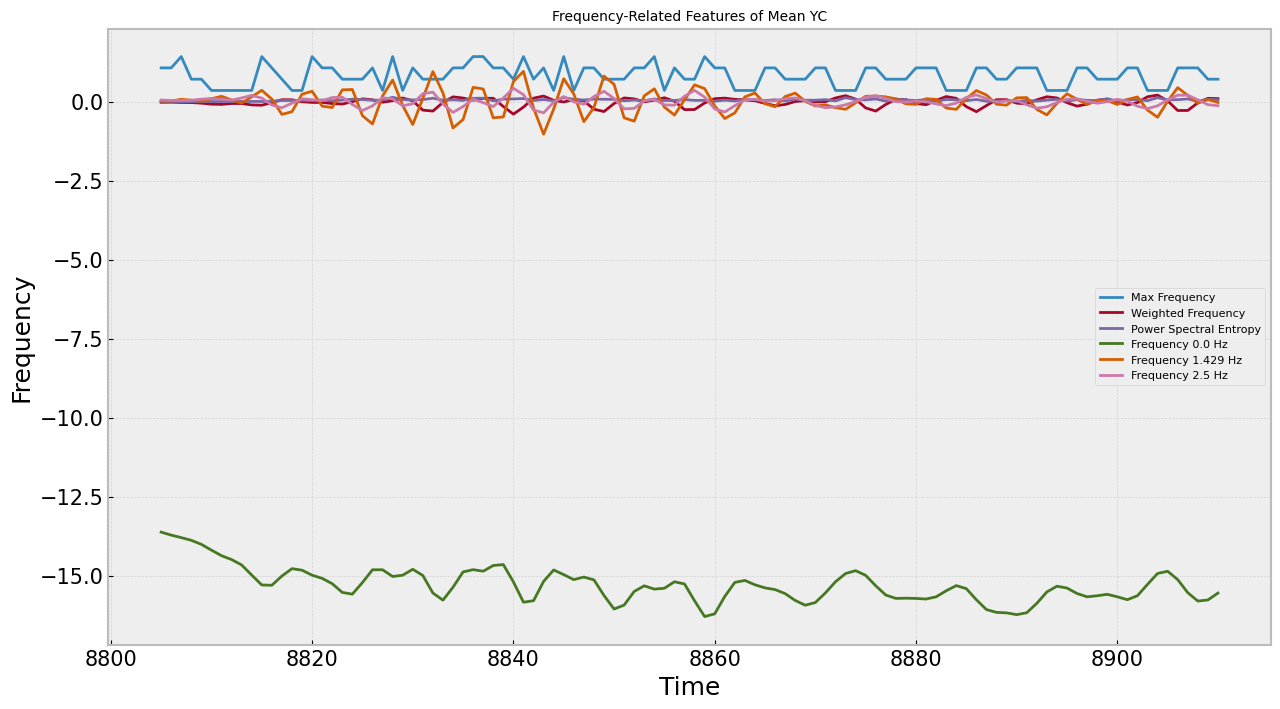

In [26]:
plt.figure(figsize=(15, 8))
plt.plot(df_subset['mean_yc_max_freq'], label='Max Frequency')
plt.plot(df_subset['mean_yc_freq_weighted'], label='Weighted Frequency')
plt.plot(df_subset['mean_yc_pse'], label='Power Spectral Entropy')
plt.plot(df_subset['mean_yc_freq_0.0_Hz_ws_14'], label='Frequency 0.0 Hz')
plt.plot(df_subset['mean_yc_freq_1.429_Hz_ws_14'], label='Frequency 1.429 Hz')
plt.plot(df_subset['mean_yc_freq_2.5_Hz_ws_14'], label='Frequency 2.5 Hz')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Frequency-Related Features of Mean YC' , fontsize=10)
plt.legend()
plt.grid(True)
plt.show()

`Looping through sets for DFT`

In [27]:
df_DFT_list = []
for s in df_DFT['set'].unique():
    print(f"Applying Fourier Transformation (DFT) for set {s}")
    subset_df = df_DFT[df_DFT['set'] == s].reset_index(drop = True).copy()
    subset_df = Freq_DFT.abstract_frequency(data_table = subset_df, cols= predicator_columns , window_size = 14, sampling_rate = 5)
    df_DFT_list.append(subset_df)
    
df_DFT = pd.concat(df_DFT_list).set_index("time" , drop = True)

Applying Fourier Transformation (DFT) for set 64.0
Applying Fourier Transformation (DFT) for set 72.0
Applying Fourier Transformation (DFT) for set 40.0
Applying Fourier Transformation (DFT) for set 86.0
Applying Fourier Transformation (DFT) for set 80.0
Applying Fourier Transformation (DFT) for set 10.0
Applying Fourier Transformation (DFT) for set 74.0
Applying Fourier Transformation (DFT) for set 52.0
Applying Fourier Transformation (DFT) for set 12.0
Applying Fourier Transformation (DFT) for set 33.0
Applying Fourier Transformation (DFT) for set 77.0
Applying Fourier Transformation (DFT) for set 53.0
Applying Fourier Transformation (DFT) for set 32.0
Applying Fourier Transformation (DFT) for set 79.0
Applying Fourier Transformation (DFT) for set 22.0
Applying Fourier Transformation (DFT) for set 17.0
Applying Fourier Transformation (DFT) for set 69.0
Applying Fourier Transformation (DFT) for set 63.0
Applying Fourier Transformation (DFT) for set 60.0
Applying Fourier Transformation

In [28]:
df_DFT

,mean_xc,mean_yc,mean_zc,mean_xg,mean_yg,mean_zg,posture,types,specimen,set,...,gyro_sqrt_freq_weighted,gyro_sqrt_pse,gyro_sqrt_freq_0.0_Hz_ws_14,gyro_sqrt_freq_0.357_Hz_ws_14,gyro_sqrt_freq_0.714_Hz_ws_14,gyro_sqrt_freq_1.071_Hz_ws_14,gyro_sqrt_freq_1.429_Hz_ws_14,gyro_sqrt_freq_1.786_Hz_ws_14,gyro_sqrt_freq_2.143_Hz_ws_14,gyro_sqrt_freq_2.5_Hz_ws_14
time,,,,,,,,,,,,,,,,,,,,,
2024-02-11 17:08:05.200,0.013496,0.977014,-0.071002,-1.891570,2.438321,0.937917,bench,heavy,B,64.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-02-11 17:08:05.400,0.008260,0.965687,-0.066392,0.744158,0.512027,0.769823,bench,heavy,B,64.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-02-11 17:08:05.600,-0.008713,0.964964,-0.072315,3.729410,-2.209350,-1.100146,bench,heavy,B,64.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-02-11 17:08:05.800,-0.024124,0.973185,-0.084830,3.502448,-3.556205,-1.863756,bench,heavy,B,64.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-02-11 17:08:06.000,-0.021642,0.963600,-0.095993,2.250385,-0.890134,-1.990244,bench,heavy,B,64.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-20 19:33:27.000,-0.043888,-0.983254,-0.062298,2.477314,-4.130471,0.211078,row,medium,E,71.0,...,-0.398460,0.268683,271.566446,-41.387135,24.866771,-5.636720,3.919922,-42.768100,-0.973890,-2.617110
2024-02-20 19:33:27.200,-0.041612,-1.045090,-0.060838,-1.825996,-2.528451,1.485679,row,medium,E,71.0,...,0.461955,0.567201,265.529496,-40.377828,42.764549,63.178238,-22.107356,44.973548,10.407563,6.625918
2024-02-20 19:33:27.400,-0.047711,-1.047383,-0.066148,-0.261306,-1.974637,1.149337,row,medium,E,71.0,...,0.572191,0.467197,236.065241,-53.266814,18.684881,41.615013,9.818577,18.563629,14.008133,24.512199


----

# **Dealing with overlapping**

In [29]:
df_DFT = df_DFT.dropna()
df_DFT

,mean_xc,mean_yc,mean_zc,mean_xg,mean_yg,mean_zg,posture,types,specimen,set,...,gyro_sqrt_freq_weighted,gyro_sqrt_pse,gyro_sqrt_freq_0.0_Hz_ws_14,gyro_sqrt_freq_0.357_Hz_ws_14,gyro_sqrt_freq_0.714_Hz_ws_14,gyro_sqrt_freq_1.071_Hz_ws_14,gyro_sqrt_freq_1.429_Hz_ws_14,gyro_sqrt_freq_1.786_Hz_ws_14,gyro_sqrt_freq_2.143_Hz_ws_14,gyro_sqrt_freq_2.5_Hz_ws_14
time,,,,,,,,,,,,,,,,,,,,,
2024-02-11 17:08:08.000,-0.171720,0.899881,-0.169511,3.774166,-9.224335,26.319263,bench,heavy,B,64.0,...,-0.957300,0.400390,169.957158,-22.769665,17.850271,6.699009,-28.838380,1.172824,-28.214163,-6.688060
2024-02-11 17:08:08.200,-0.076470,0.839325,-0.095650,8.706837,-7.451097,17.150265,bench,heavy,B,64.0,...,-1.101747,0.286032,187.358437,-14.655543,-8.260736,1.541356,-39.634208,-18.439202,1.805367,-7.135015
2024-02-11 17:08:08.400,-0.025599,0.868121,-0.058455,6.531859,-2.034554,1.905407,bench,heavy,B,64.0,...,-0.281933,0.338735,193.273377,-16.005057,-42.348706,-21.319861,19.104626,-3.092371,3.106451,-2.540710
2024-02-11 17:08:08.600,-0.038508,0.953873,-0.046010,0.221772,0.154323,-3.698413,bench,heavy,B,64.0,...,-0.048133,0.538571,192.509505,-21.199924,-54.838966,-20.868745,29.805160,15.998570,-12.128665,6.937633
2024-02-11 17:08:08.800,-0.062526,0.990899,-0.034507,-1.000984,-1.663903,-0.937159,bench,heavy,B,64.0,...,-0.440818,0.382233,189.337639,-24.862902,-32.398674,8.205980,-24.240179,-10.556393,19.848106,-7.164922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-20 19:33:27.000,-0.043888,-0.983254,-0.062298,2.477314,-4.130471,0.211078,row,medium,E,71.0,...,-0.398460,0.268683,271.566446,-41.387135,24.866771,-5.636720,3.919922,-42.768100,-0.973890,-2.617110
2024-02-20 19:33:27.200,-0.041612,-1.045090,-0.060838,-1.825996,-2.528451,1.485679,row,medium,E,71.0,...,0.461955,0.567201,265.529496,-40.377828,42.764549,63.178238,-22.107356,44.973548,10.407563,6.625918
2024-02-20 19:33:27.400,-0.047711,-1.047383,-0.066148,-0.261306,-1.974637,1.149337,row,medium,E,71.0,...,0.572191,0.467197,236.065241,-53.266814,18.684881,41.615013,9.818577,18.563629,14.008133,24.512199


In [30]:
df_DFT = df_DFT.iloc[::2]

In [31]:
df_DFT

,mean_xc,mean_yc,mean_zc,mean_xg,mean_yg,mean_zg,posture,types,specimen,set,...,gyro_sqrt_freq_weighted,gyro_sqrt_pse,gyro_sqrt_freq_0.0_Hz_ws_14,gyro_sqrt_freq_0.357_Hz_ws_14,gyro_sqrt_freq_0.714_Hz_ws_14,gyro_sqrt_freq_1.071_Hz_ws_14,gyro_sqrt_freq_1.429_Hz_ws_14,gyro_sqrt_freq_1.786_Hz_ws_14,gyro_sqrt_freq_2.143_Hz_ws_14,gyro_sqrt_freq_2.5_Hz_ws_14
time,,,,,,,,,,,,,,,,,,,,,
2024-02-11 17:08:08.000,-0.171720,0.899881,-0.169511,3.774166,-9.224335,26.319263,bench,heavy,B,64.0,...,-0.957300,0.400390,169.957158,-22.769665,17.850271,6.699009,-28.838380,1.172824,-28.214163,-6.688060
2024-02-11 17:08:08.400,-0.025599,0.868121,-0.058455,6.531859,-2.034554,1.905407,bench,heavy,B,64.0,...,-0.281933,0.338735,193.273377,-16.005057,-42.348706,-21.319861,19.104626,-3.092371,3.106451,-2.540710
2024-02-11 17:08:08.800,-0.062526,0.990899,-0.034507,-1.000984,-1.663903,-0.937159,bench,heavy,B,64.0,...,-0.440818,0.382233,189.337639,-24.862902,-32.398674,8.205980,-24.240179,-10.556393,19.848106,-7.164922
2024-02-11 17:08:09.200,-0.045753,0.976997,-0.037550,4.534213,-3.075271,2.630137,bench,heavy,B,64.0,...,0.415119,0.447621,185.520071,-17.510089,48.136639,6.703348,27.660469,14.735488,12.349908,-5.934444
2024-02-11 17:08:09.600,-0.046297,0.906045,-0.056705,1.308300,2.464768,-4.722314,bench,heavy,B,64.0,...,-0.648024,0.328161,150.511413,-22.125228,17.002075,-6.599336,-10.310644,8.862907,-13.328693,-15.904520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-20 19:33:26.200,0.063193,-0.942315,0.107890,-26.048703,8.594212,15.067990,row,medium,E,71.0,...,-1.047788,0.268295,307.024981,10.671412,-45.269619,12.890568,-29.181884,-21.399785,-11.857030,-31.989505
2024-02-20 19:33:26.600,-0.023519,-1.200629,-0.109648,-3.410697,-1.614197,6.195765,row,medium,E,71.0,...,0.410947,0.198346,315.207393,9.031439,-5.194140,-5.327670,15.552368,58.996852,18.923583,2.574359
2024-02-20 19:33:27.000,-0.043888,-0.983254,-0.062298,2.477314,-4.130471,0.211078,row,medium,E,71.0,...,-0.398460,0.268683,271.566446,-41.387135,24.866771,-5.636720,3.919922,-42.768100,-0.973890,-2.617110


- Finally here i can tell i used downsampling technique by selecting every other row provides a practical solution to address issues related to correlated values in datasets generated using overlapping window processes. By reducing dataset size while preserving essential information, it promotes better model generalization and performance.

- we note that we start at zero, then proceed to 200, and finally to 400. Upon comparison with the original dataframe, we find that it also starts at zero and ends at 400. However, in the downsampled dataframe, we skip the index 200, effectively removing every other row. 

-------

# **Clustering**

In [32]:
cluster_df = df_DFT.copy()
cluster_df

,mean_xc,mean_yc,mean_zc,mean_xg,mean_yg,mean_zg,posture,types,specimen,set,...,gyro_sqrt_freq_weighted,gyro_sqrt_pse,gyro_sqrt_freq_0.0_Hz_ws_14,gyro_sqrt_freq_0.357_Hz_ws_14,gyro_sqrt_freq_0.714_Hz_ws_14,gyro_sqrt_freq_1.071_Hz_ws_14,gyro_sqrt_freq_1.429_Hz_ws_14,gyro_sqrt_freq_1.786_Hz_ws_14,gyro_sqrt_freq_2.143_Hz_ws_14,gyro_sqrt_freq_2.5_Hz_ws_14
time,,,,,,,,,,,,,,,,,,,,,
2024-02-11 17:08:08.000,-0.171720,0.899881,-0.169511,3.774166,-9.224335,26.319263,bench,heavy,B,64.0,...,-0.957300,0.400390,169.957158,-22.769665,17.850271,6.699009,-28.838380,1.172824,-28.214163,-6.688060
2024-02-11 17:08:08.400,-0.025599,0.868121,-0.058455,6.531859,-2.034554,1.905407,bench,heavy,B,64.0,...,-0.281933,0.338735,193.273377,-16.005057,-42.348706,-21.319861,19.104626,-3.092371,3.106451,-2.540710
2024-02-11 17:08:08.800,-0.062526,0.990899,-0.034507,-1.000984,-1.663903,-0.937159,bench,heavy,B,64.0,...,-0.440818,0.382233,189.337639,-24.862902,-32.398674,8.205980,-24.240179,-10.556393,19.848106,-7.164922
2024-02-11 17:08:09.200,-0.045753,0.976997,-0.037550,4.534213,-3.075271,2.630137,bench,heavy,B,64.0,...,0.415119,0.447621,185.520071,-17.510089,48.136639,6.703348,27.660469,14.735488,12.349908,-5.934444
2024-02-11 17:08:09.600,-0.046297,0.906045,-0.056705,1.308300,2.464768,-4.722314,bench,heavy,B,64.0,...,-0.648024,0.328161,150.511413,-22.125228,17.002075,-6.599336,-10.310644,8.862907,-13.328693,-15.904520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-20 19:33:26.200,0.063193,-0.942315,0.107890,-26.048703,8.594212,15.067990,row,medium,E,71.0,...,-1.047788,0.268295,307.024981,10.671412,-45.269619,12.890568,-29.181884,-21.399785,-11.857030,-31.989505
2024-02-20 19:33:26.600,-0.023519,-1.200629,-0.109648,-3.410697,-1.614197,6.195765,row,medium,E,71.0,...,0.410947,0.198346,315.207393,9.031439,-5.194140,-5.327670,15.552368,58.996852,18.923583,2.574359
2024-02-20 19:33:27.000,-0.043888,-0.983254,-0.062298,2.477314,-4.130471,0.211078,row,medium,E,71.0,...,-0.398460,0.268683,271.566446,-41.387135,24.866771,-5.636720,3.919922,-42.768100,-0.973890,-2.617110


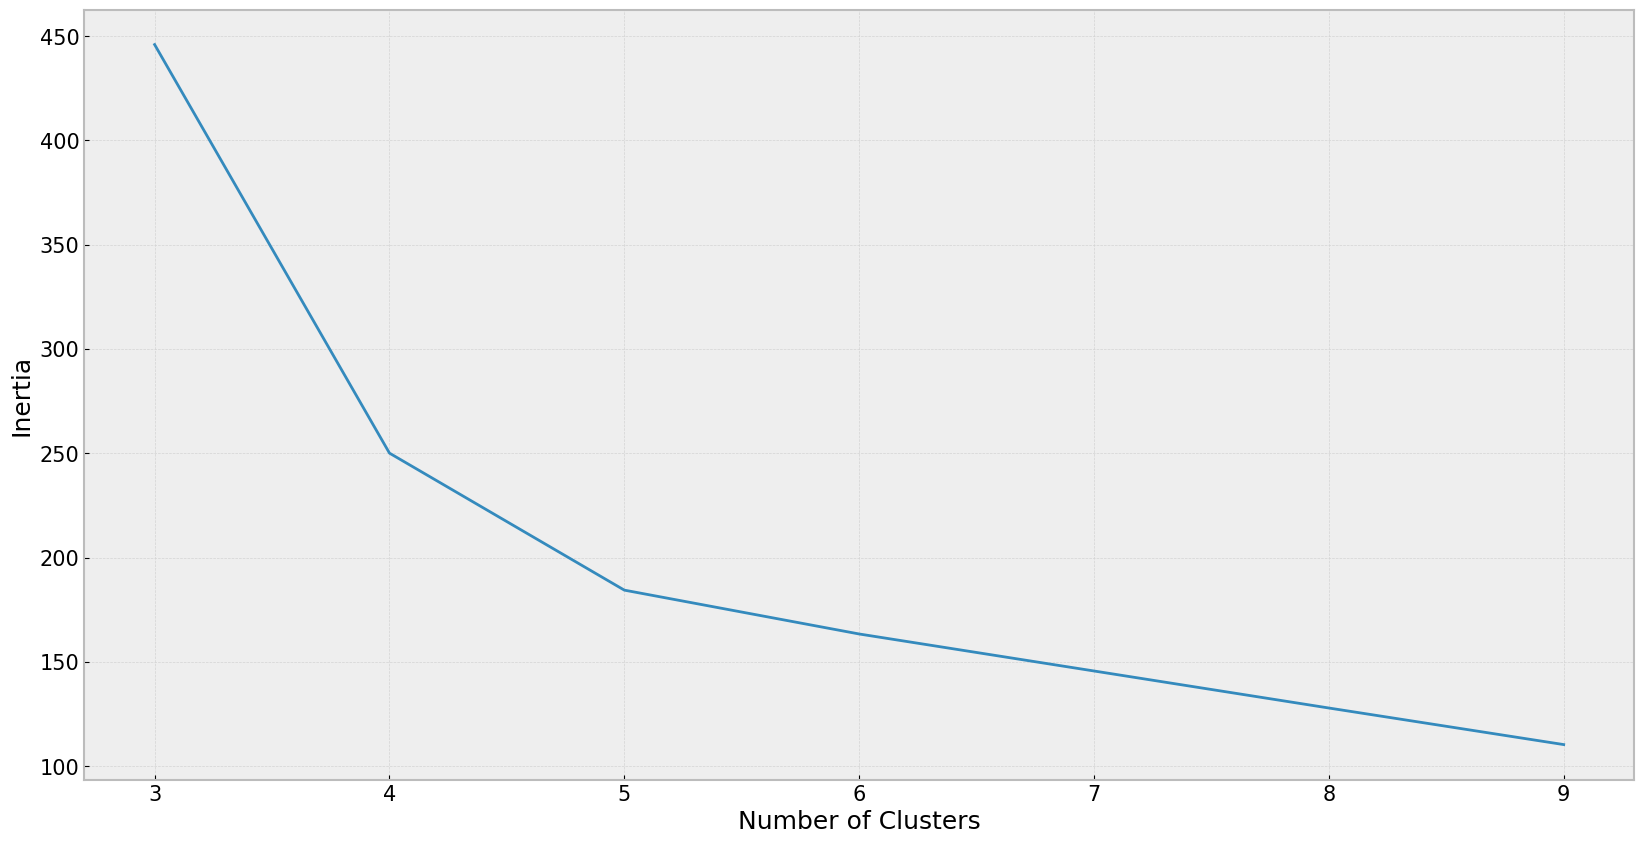

In [33]:
k_values = range(3,10)
intertials = [] 
cluster_col = ['mean_xc' , 'mean_yc', 'mean_zc']

for k in k_values:
    subset_df = cluster_df[cluster_col]
    kmeans_model = KMeans(n_clusters = k , n_init= 20 , random_state = 0)
    pre_cluster = kmeans_model.fit_predict(subset_df)
    intertials.append(kmeans_model.inertia_)
    
    
plt.plot(k_values , intertials)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [34]:
kmeans_model = KMeans(n_clusters= 5 , n_init= 20 , random_state = 0)
subset_df = cluster_df[cluster_col]
cluster_df['cluster'] = kmeans_model.fit_predict(subset_df)
cluster_df.cluster.unique()

array([1, 4, 0, 2, 3], dtype=int32)

## Plotting clustering in 3D

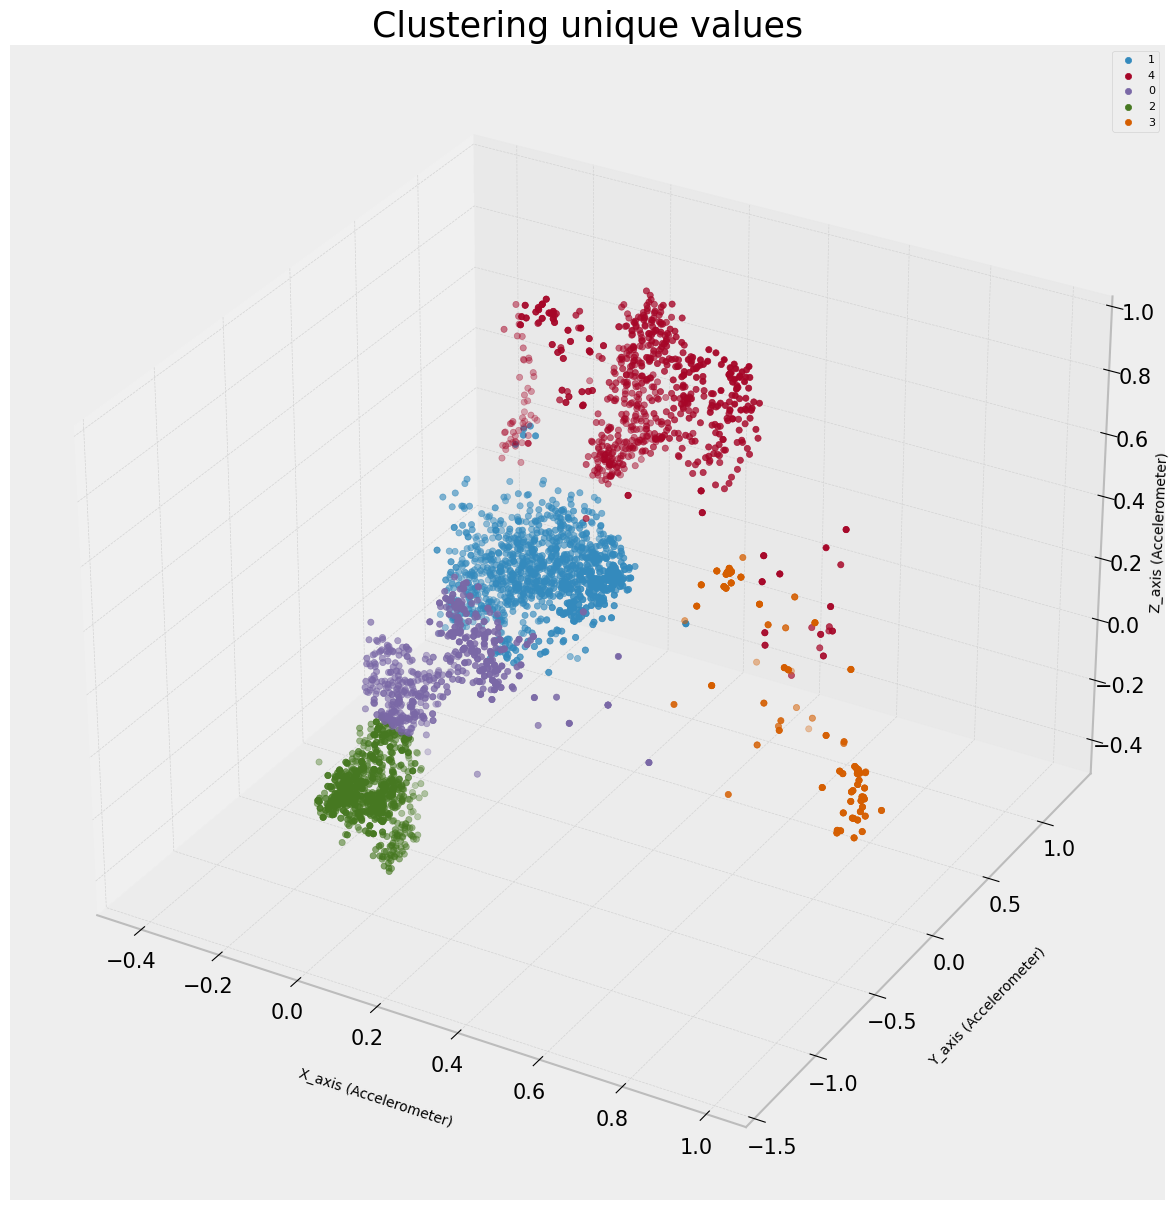

In [35]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
# Iterate over unique clusters
for cluster in cluster_df.cluster.unique():
    subset_df = cluster_df[cluster_df.cluster == cluster]
    ax.scatter(subset_df['mean_xc'], subset_df['mean_yc'], subset_df['mean_zc'], label=cluster)
ax.set_xlabel('X_axis (Accelerometer)', fontsize=10, labelpad=20)
ax.set_ylabel('Y_axis (Accelerometer)' , fontsize = 10, labelpad = 20)
ax.set_zlabel('Z_axis (Accelerometer)', fontsize = 10, labelpad = 5)
ax.set_title ('Clustering unique values', fontsize=25)
ax.legend()
plt.show()

## Ploting clustering Accelerometer data for Posture Classification

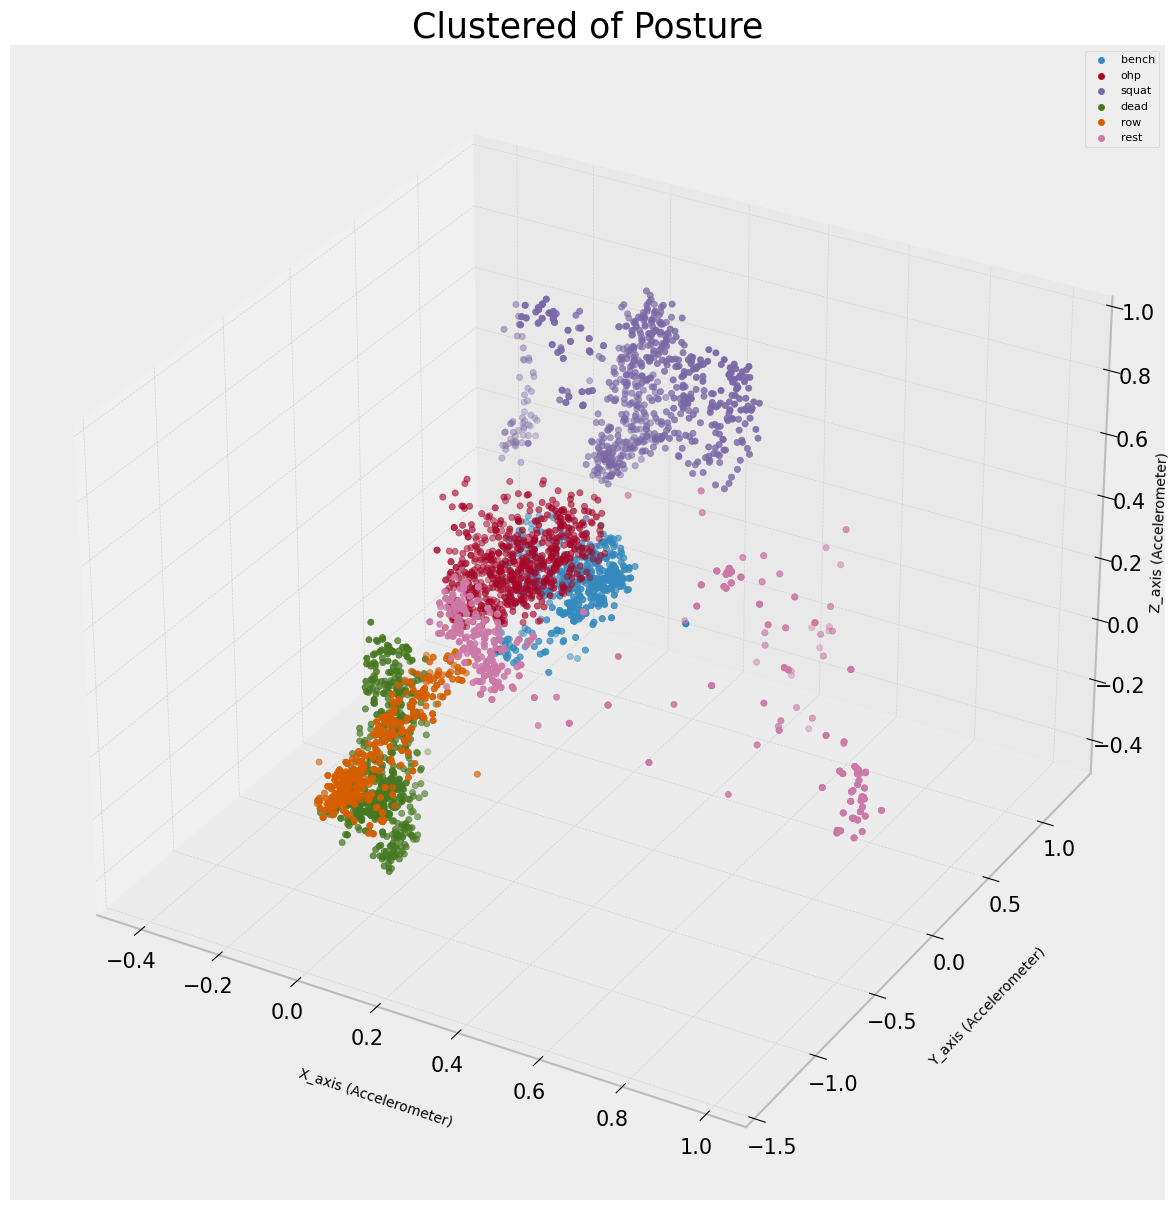

In [36]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
# Iterate over unique posture
for pos in cluster_df.posture.unique():
    subset_df = cluster_df[cluster_df.posture == pos]
    ax.scatter(subset_df['mean_xc'], subset_df['mean_yc'], subset_df['mean_zc'], label=pos)
ax.set_xlabel('X_axis (Accelerometer)', fontsize=10, labelpad=20)
ax.set_ylabel('Y_axis (Accelerometer)' , fontsize = 10, labelpad = 20)
ax.set_zlabel('Z_axis (Accelerometer)', fontsize = 10, labelpad = 5)
ax.set_title ('Clustered of Posture', fontsize=25)
ax.legend()
plt.show()

In [38]:
cluster_df

,mean_xc,mean_yc,mean_zc,mean_xg,mean_yg,mean_zg,posture,types,specimen,set,...,gyro_sqrt_pse,gyro_sqrt_freq_0.0_Hz_ws_14,gyro_sqrt_freq_0.357_Hz_ws_14,gyro_sqrt_freq_0.714_Hz_ws_14,gyro_sqrt_freq_1.071_Hz_ws_14,gyro_sqrt_freq_1.429_Hz_ws_14,gyro_sqrt_freq_1.786_Hz_ws_14,gyro_sqrt_freq_2.143_Hz_ws_14,gyro_sqrt_freq_2.5_Hz_ws_14,cluster
time,,,,,,,,,,,,,,,,,,,,,
2024-02-11 17:08:08.000,-0.171720,0.899881,-0.169511,3.774166,-9.224335,26.319263,bench,heavy,B,64.0,...,0.400390,169.957158,-22.769665,17.850271,6.699009,-28.838380,1.172824,-28.214163,-6.688060,1
2024-02-11 17:08:08.400,-0.025599,0.868121,-0.058455,6.531859,-2.034554,1.905407,bench,heavy,B,64.0,...,0.338735,193.273377,-16.005057,-42.348706,-21.319861,19.104626,-3.092371,3.106451,-2.540710,1
2024-02-11 17:08:08.800,-0.062526,0.990899,-0.034507,-1.000984,-1.663903,-0.937159,bench,heavy,B,64.0,...,0.382233,189.337639,-24.862902,-32.398674,8.205980,-24.240179,-10.556393,19.848106,-7.164922,1
2024-02-11 17:08:09.200,-0.045753,0.976997,-0.037550,4.534213,-3.075271,2.630137,bench,heavy,B,64.0,...,0.447621,185.520071,-17.510089,48.136639,6.703348,27.660469,14.735488,12.349908,-5.934444,1
2024-02-11 17:08:09.600,-0.046297,0.906045,-0.056705,1.308300,2.464768,-4.722314,bench,heavy,B,64.0,...,0.328161,150.511413,-22.125228,17.002075,-6.599336,-10.310644,8.862907,-13.328693,-15.904520,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-20 19:33:26.200,0.063193,-0.942315,0.107890,-26.048703,8.594212,15.067990,row,medium,E,71.0,...,0.268295,307.024981,10.671412,-45.269619,12.890568,-29.181884,-21.399785,-11.857030,-31.989505,0
2024-02-20 19:33:26.600,-0.023519,-1.200629,-0.109648,-3.410697,-1.614197,6.195765,row,medium,E,71.0,...,0.198346,315.207393,9.031439,-5.194140,-5.327670,15.552368,58.996852,18.923583,2.574359,2
2024-02-20 19:33:27.000,-0.043888,-0.983254,-0.062298,2.477314,-4.130471,0.211078,row,medium,E,71.0,...,0.268683,271.566446,-41.387135,24.866771,-5.636720,3.919922,-42.768100,-0.973890,-2.617110,2


-------

# **Export Data**

In [37]:
cluster_df.to_pickle(EXPORT_PATH)